# FIFA 21 Dataset Analysis and Cleaning: Exploring Football Players

This notebook explores and cleans a "messy" FIFA 21 dataset scraped from sofifa.com. The goal is to understand its structure, fix problematic data, and prepare it for analysis. We'll proceed step-by-step, documenting each decision for clarity and future reference.

---

## About the Dataset

- **Source**: Kaggle, uploaded by yagunnersya, scraped from sofifa.com.
- **Size**: 18,979 rows (players) and 77 columns.
- **Content**: Player details including names, nationalities, ages, heights, weights, wages, market values, clubs, and game stats.
- **Feature**: A "messy" dataset ideal for practicing data cleaning (e.g., heights as text, wages with symbols).

---

## Initial Objectives

- Inspect the dataset structure and identify issues (nulls, odd formats).
- Convert columns like `'Height'`, `'Weight'`, `'Value'`, and `'Wage'` to numerical formats.
- Find players who have been with a club for over 10 years using `'Joined'`.
- Explore the relationship between `'Value'` and `'Wage'` to identify highly valuable but underpaid players.
- Answer custom questions, such as: Which countries have the most players? Which clubs have the most valuable players?

---

## 1. Loading the Data

We'll start by loading the dataset and confirming it works correctly.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datetime import datetime  # For handling date conversions
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fifa-21-messy-raw-dataset-for-cleaning-exploring/fifa21 raw data v2.csv
/kaggle/input/fifa-21-messy-raw-dataset-for-cleaning-exploring/fifa21_raw_data.csv


In [2]:
# Load the dataset from the Kaggle input directory
df = pd.read_csv('/kaggle/input/fifa-21-messy-raw-dataset-for-cleaning-exploring/fifa21 raw data v2.csv')

# isplay the first few rows to verify loading
print(df.head())

       ID               Name                      LongName  \
0  158023           L. Messi                  Lionel Messi   
1   20801  Cristiano Ronaldo  C. Ronaldo dos Santos Aveiro   
2  200389           J. Oblak                     Jan Oblak   
3  192985       K. De Bruyne               Kevin De Bruyne   
4  190871          Neymar Jr    Neymar da Silva Santos Jr.   

                                           photoUrl  \
0  https://cdn.sofifa.com/players/158/023/21_60.png   
1  https://cdn.sofifa.com/players/020/801/21_60.png   
2  https://cdn.sofifa.com/players/200/389/21_60.png   
3  https://cdn.sofifa.com/players/192/985/21_60.png   
4  https://cdn.sofifa.com/players/190/871/21_60.png   

                                           playerUrl Nationality  Age  ↓OVA  \
0  http://sofifa.com/player/158023/lionel-messi/2...   Argentina   33    93   
1  http://sofifa.com/player/20801/c-ronaldo-dos-s...    Portugal   35    92   
2  http://sofifa.com/player/200389/jan-oblak/210006/    Slo

---

## 2. Initial Inspection

Let’s understand the dataset's structure, check for missing values, and identify duplicates.

In [3]:
#Number of entries, data types, number of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18979 entries, 0 to 18978
Data columns (total 77 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                18979 non-null  int64 
 1   Name              18979 non-null  object
 2   LongName          18979 non-null  object
 3   photoUrl          18979 non-null  object
 4   playerUrl         18979 non-null  object
 5   Nationality       18979 non-null  object
 6   Age               18979 non-null  int64 
 7   ↓OVA              18979 non-null  int64 
 8   POT               18979 non-null  int64 
 9   Club              18979 non-null  object
 10  Contract          18979 non-null  object
 11  Positions         18979 non-null  object
 12  Height            18979 non-null  object
 13  Weight            18979 non-null  object
 14  Preferred Foot    18979 non-null  object
 15  BOV               18979 non-null  int64 
 16  Best Position     18979 non-null  object
 17  Joined      

In [4]:
# Check for missing values
df.isnull().sum()

ID              0
Name            0
LongName        0
photoUrl        0
playerUrl       0
             ... 
PAS             0
DRI             0
DEF             0
PHY             0
Hits         2595
Length: 77, dtype: int64

In [5]:
#check if we have duplicated football players
df['ID'].duplicated().sum()

0

In [6]:
#check if we have duplicated columns
duplicate_column_names = df.columns[df.columns.duplicated()].tolist()

if duplicate_column_names:
    print(f"Duplicate column names: {duplicate_column_names}")
else:
    print("No duplicate column names found.")

No duplicate column names found.


### Observations
- **Rows and Columns**: 18,979 players, 77 columns.
- **Data Types**: Many columns are `object` (text), even ones that should be numeric (e.g., `'Height'`, `'Value'`).
- **Missing Values**: We’ll address these later if relevant to our objectives.
- **Duplicates**: No duplicate IDs or columns expected, but good to confirm.

---

### 2.1 Identifying Key Columns

With 77 columns, we can’t analyze everything. Let’s focus on columns critical to our objectives or with problematic formats.

In [7]:
# Select columns of interest for initial inspection
key_columns = ['Height', 'Weight', 'Joined', 'Value', 'Wage', 'Release Clause']
print("\nSample of key columns:")
print(df[key_columns].head())
print("\nData types of key columns:")
print(df[key_columns].dtypes)


Sample of key columns:
  Height Weight        Joined    Value   Wage Release Clause
0  170cm   72kg   Jul 1, 2004  €103.5M  €560K        €138.4M
1  187cm   83kg  Jul 10, 2018     €63M  €220K         €75.9M
2  188cm   87kg  Jul 16, 2014    €120M  €125K        €159.4M
3  181cm   70kg  Aug 30, 2015    €129M  €370K          €161M
4  175cm   68kg   Aug 3, 2017    €132M  €270K        €166.5M

Data types of key columns:
Height            object
Weight            object
Joined            object
Value             object
Wage              object
Release Clause    object
dtype: object


In [8]:
# Explore unique values to understand formats
#print("\nUnique values in 'Height':", df['Height'].unique())
#print("\nUnique values in 'Weight':", df['Weight'].unique())

### Findings
- **Problematic Formats**:
  - `'Height'`: Mixed units (`'170cm'`, `'6\'2"'`).
  - `'Weight'`: Mixed units (`'72kg'`, `'183lbs'`).
  - `'Value'`, `'Wage'`, `'Release Clause'`: Currency with symbols (`'€103.5M'`, `'€560K'`).
  - `'Joined'`: Text dates (`'Jul 1, 2004'`).
- **Goal**: Convert these to numeric formats for analysis.

---

## 3. Data Cleaning and Transformation

We’ll create a copy of the dataset and define functions to clean and transform these columns.

### 3.1 Creating a Working Copy

In [9]:
# Create a copy to preserve the original data
df2 = df.copy()

### 3.2 Cleaning Functions

Let’s define functions to handle units and formats.

In [10]:
# Function to convert height and weight to numeric (cm and kg)
def convert_units(x):
    """
    Convert height or weight to numeric values:
    - 'cm' or 'kg': Remove suffix and convert to int.
    - 'lbs': Convert to kg (1 lb = 0.453592 kg) and round.
    - Feet/inches (e.g., '6\'2"'): Convert to cm (1 ft = 30.48 cm, 1 in = 2.54 cm).
    """
    if isinstance(x, str):
        if x.endswith('cm') or x.endswith('kg'):
            return int(x[:-2])
        elif x.endswith('lbs'):
            return int(round(int(x[:-3]) * 0.453592, 0))
        elif "'" in x:
            feet, inches = x.split("'")
            inches = inches.strip('"')
            return int(round((int(feet) * 30.48) + (int(inches) * 2.54), 0))
    return x  # Return unchanged if not a string

In [11]:
print(convert_units('170cm'))   
print(convert_units('72kg'))    
print(convert_units('183lbs'))  
print(convert_units('6\'2"'))   

170
72
83
188


Now let´s create the function to change into numeric value the columns 'Value', 'Wage', 'Release Clause'

In [12]:
#print(df['Value'].unique())
#print(df['Wage'].unique())
#print(df['Release Clause'].unique())

In [13]:
# Function to convert money values to numeric
def convert_money(x):
    """
    Convert monetary values to numeric:
    - Remove '€' symbol.
    - 'M': Multiply by 1,000,000.
    - 'K': Multiply by 1,000.
    - '€0' or other: Return 0 or numeric value.
    """
    if isinstance(x, str) and '€' in x:
        x = x.replace('€', '')
        if x == '0':
            return 0.0
        elif x.endswith('M'):
            return float(x[:-1]) * 1_000_000
        elif x.endswith('K'):
            return float(x[:-1]) * 1_000
        else:
            return float(x)
    return x  # Return unchanged if not a string

In [14]:
print(convert_money('€103.5M'))   
print(convert_money('€270.5K')) 
print(convert_money('€0'))  

103500000.0
270500.0
0.0


Now let´s transform Joined into numeric, we just want the year

In [15]:
# Function to extract year from 'Joined'
def extract_year(x):
    """Extract the year from a date string (e.g., 'Jul 1, 2004' -> 2004)."""
    if isinstance(x, str) and ',' in x:
        return int(x.split(',')[1].strip())
    return pd.NA

In [16]:
print (extract_year('Jul 1, 2004'))

2004


In [17]:
# Functions for 'Contract' column
def get_contract_type(x):
    """Determine the type of contract: 'Free', 'Loan', or 'Contract'."""
    if isinstance(x, str):
        if "Free" in x:
            return "Free"
        elif "Loan" in x:
            return "Loan"
        elif "~" in x:
            return "Contract"
    return pd.NA

In [18]:
def get_start_time(x):
    """Extract the start year or date from 'Contract'."""
    if isinstance(x, str):
        if "~" in x:
            return int(x[:4])  # e.g., '2004 ~ 2021' -> 2004
        elif "Loan" in x:
            loan_date = x.replace(" On Loan", "").strip()
            return datetime.strptime(loan_date, "%b %d, %Y").date()
    return pd.NA

In [19]:
def get_end_time(x, loan_date_end=None):
    """Extract the end year or date from 'Contract' or 'Loan Date End'."""
    if isinstance(x, str):
        if "~" in x:
            return int(x[-4:])  # e.g., '2004 ~ 2021' -> 2021
        elif "Loan" in x and loan_date_end:
            return datetime.strptime(loan_date_end, "%b %d, %Y").date()
    return pd.NA

### 3.3 Applying Transformations

In [20]:
# Apply unit conversions
df2['Height'] = df2['Height'].apply(convert_units)
df2['Weight'] = df2['Weight'].apply(convert_units)

In [21]:
#print(df2['Height'].unique())
#print(df2['Weight'].unique())

In [22]:
# Apply money conversions
df2['Value'] = df2['Value'].apply(convert_money)
df2['Wage'] = df2['Wage'].apply(convert_money)
df2['Release Clause'] = df2['Release Clause'].apply(convert_money)

In [23]:
#print(df2['Value'].unique())
#print(df2['Wage'].unique())
#print(df2['Release Clause'].unique())

In [24]:
# Convert 'Joined' to year
df2['Joined'] = df2['Joined'].apply(extract_year)

In [25]:
#print(df2['Joined'].unique())

In [26]:
# Apply contract transformations
df2['Contract Type'] = df2['Contract'].apply(get_contract_type)
df2['Start Year'] = df2['Contract'].apply(get_start_time)
df2['End Year'] = df2.apply(lambda row: get_end_time(row['Contract'], row['Loan Date End']), axis=1)

In [27]:
# Reorder columns and drop 'Loan Date End'
original_cols = df.columns[:7].tolist()  # First 7 columns from original
new_cols = ['Contract Type', 'Start Year', 'End Year']
middle_cols = [col for col in df2.columns if col not in original_cols + new_cols + ['Loan Date End']]

# Reorder without including 'Loan Date End' explicitly in drop since it's already excluded
df2 = df2[original_cols + new_cols + middle_cols]

# No need to drop 'Loan Date End' again since it's not in the reordered DataFrame
# Verify the columns to confirm
print("\nColumns after reordering:", df2.columns.tolist())


Columns after reordering: ['ID', 'Name', 'LongName', 'photoUrl', 'playerUrl', 'Nationality', 'Age', 'Contract Type', 'Start Year', 'End Year', '↓OVA', 'POT', 'Club', 'Contract', 'Positions', 'Height', 'Weight', 'Preferred Foot', 'BOV', 'Best Position', 'Joined', 'Value', 'Wage', 'Release Clause', 'Attacking', 'Crossing', 'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys', 'Skill', 'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control', 'Movement', 'Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance', 'Power', 'Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots', 'Mentality', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Defending', 'Marking', 'Standing Tackle', 'Sliding Tackle', 'Goalkeeping', 'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes', 'Total Stats', 'Base Stats', 'W/F', 'SM', 'A/W', 'D/W', 'IR', 'PAC', 'SHO', 'PAS', 'DRI', 'DEF', 'PHY', 'Hits']


In [28]:
# Rename columns for clarity
df2 = df2.rename(columns={
    'Height': 'Height (cm)',
    'Weight': 'Weight (kg)',
    'Value': 'Market Value (EUR)',
    'Wage': 'Weekly Wage (EUR)',
    'Release Clause': 'Release Clause (EUR)',
    '↓OVA': 'OVA'
})

# Verify transformations
print("\nTransformed key columns:")
print(df2[['Height (cm)', 'Weight (kg)', 'Joined', 'Market Value (EUR)', 'Weekly Wage (EUR)', 'Release Clause (EUR)', 'OVA']].head())



Transformed key columns:
   Height (cm)  Weight (kg)  Joined  Market Value (EUR)  Weekly Wage (EUR)  \
0          170           72    2004         103500000.0           560000.0   
1          187           83    2018          63000000.0           220000.0   
2          188           87    2014         120000000.0           125000.0   
3          181           70    2015         129000000.0           370000.0   
4          175           68    2017         132000000.0           270000.0   

   Release Clause (EUR)  OVA  
0           138400000.0   93  
1            75900000.0   92  
2           159400000.0   91  
3           161000000.0   91  
4           166500000.0   91  


In [29]:
#print("\nUnique values after transformation:")
#print("Height (cm):", df2['Height (cm)'].unique())
#print("Weight (kg):", df2['Weight (kg)'].unique())

### 3.4 Removing Unnecessary Characters

The dataset contains `\n` and `★` in some columns. Let’s clean them.

In [30]:
df2[['W/F','SM','IR']].head()

,W/F,SM,IR
0,4 ★,4★,5 ★
1,4 ★,5★,5 ★
2,3 ★,1★,3 ★
3,5 ★,4★,4 ★
4,5 ★,5★,5 ★


In [31]:
# Remove newline characters and stars from text columns
for col in df2.columns:
    if df2[col].dtype == 'object':
        df2[col] = df2[col].str.replace('\n', '', regex=False).str.replace('★', '', regex=False)

# Verify cleaning
print("\nAfter removing \\n and ★:")
print(df2[['Club', 'W/F', 'SM', 'IR']].head())


After removing \n and ★:
                  Club W/F SM  IR
0         FC Barcelona  4   4  5 
1             Juventus  4   5  5 
2      Atlético Madrid  3   1  3 
3      Manchester City  5   4  4 
4  Paris Saint-Germain  5   5  5 


### 3.5 Transforming Skill Attributes

The columns `'Attacking'`, `'Skill'`, `'Movement'`, `'Power'`, `'Mentality'`, `'Defending'`, and `'Goalkeeping'` represent total scores calculated as the sum of specific sub-attributes from FIFA 21. These sub-attributes come from detailed player statistics in the game (Career Mode and FUT), scraped from sofifa.com. Below is a breakdown of how many sub-attributes make up each category and why they are divided by 5, 6, or 3 to obtain averages:

- **`Attacking` ÷ 5**: Sum of 5 attacking sub-attributes.
  - Crossing, Finishing, Heading Accuracy, Short Passing, Volleys.
- **`Skill` ÷ 5**: Sum of 5 technical sub-attributes.
  - Dribbling, Curve, Free Kick Accuracy, Long Passing, Ball Control.
- **`Movement` ÷ 5**: Sum of 5 movement sub-attributes.
  - Acceleration, Sprint Speed, Agility, Reactions, Balance.
- **`Power` ÷ 5**: Sum of 5 physical power sub-attributes.
  - Shot Power, Jumping, Stamina, Strength, Long Shots.
- **`Mentality` ÷ 6**: Sum of 6 mental/tactical sub-attributes.
  - Aggression, Interceptions, Positioning, Vision, Penalties, Composure.
- **`Defending` ÷ 3**: Sum of 3 defensive sub-attributes.
  - Interceptions, Marking, Standing Tackle.
- **`Goalkeeping` ÷ 5**: Sum of 5 goalkeeping sub-attributes.
  - Diving, Handling, Kicking, Positioning, Reflexes.

### Source
- **Dataset**: Scraped from sofifa.com for FIFA 21.
- **Logic**: Based on the attribute structure of FIFA Ultimate Team and Career Mode, deduced by the community (e.g., fifauteam.com, Reddit forums).
- **Purpose**: Dividing by the number of sub-attributes (5, 6, or 3) converts totals into per-skill averages, normalized to a 0-100 scale, making them easier to interpret.

In [32]:
# Define skill categories and their divisors
skill_categories = {
    'Attacking': 5,    # Crossing, Finishing, Heading Accuracy, Short Passing, Volleys
    'Skill': 5,        # Dribbling, Curve, FK Accuracy, Long Passing, Ball Control
    'Movement': 5,     # Acceleration, Sprint Speed, Agility, Reactions, Balance
    'Power': 5,        # Shot Power, Jumping, Stamina, Strength, Long Shots
    'Mentality': 6,    # Aggression, Interceptions, Positioning, Vision, Penalties, Composure
    'Defending': 3,    # Interceptions, Marking, Standing Tackle
    'Goalkeeping': 5   # Diving, Handling, Kicking, Positioning, Reflexes
}

# Function to calculate averages
def compute_skill_averages(df, categories):
    """Compute averages for skill columns and rename them."""
    for col, divisor in categories.items():
        df[col] = (df[col] / divisor).round(0).astype('int64')
    return df.rename(columns={col: f'{col} Avg' for col in categories.keys()})

In [33]:
# Apply transformation
df2 = compute_skill_averages(df2, skill_categories)

# Verify
print("\nSkill averages:")
print(df2[[f'{col} Avg' for col in skill_categories.keys()]].head())


Skill averages:
   Attacking Avg  Skill Avg  Movement Avg  Power Avg  Mentality Avg  \
0             86         94            90         78             58   
1             87         83            86         89             59   
2             19         22            61         54             23   
3             81         88            80         82             68   
4             82         90            91         71             59   

   Defending Avg  Goalkeeping Avg  
0             30               11  
1             28               12  
2             19               87  
3             62               11  
4             31               12  


### 3.6 Handling 'Hits' Column

In [34]:
# Function to convert 'Hits' to numeric (in thousands)
def parse_hits(x):
    """Convert 'Hits' to numeric: 'K' -> thousands, else as-is."""
    if pd.isna(x):
        return np.nan
    elif isinstance(x, str) and 'K' in x:
        return float(x.replace('K', '')) * 1000
    return float(x)

In [35]:
# Apply and replace 'Hits'
df2['Hits (K)'] = df2['Hits'].apply(parse_hits)
df2 = df2.drop(columns=['Hits'])

# Fill missing values with mean
df2['Hits (K)'] = df2['Hits (K)'].fillna(df2['Hits (K)'].mean())

In [36]:
# Verify
print("\n'Hits (K)' after transformation:")
print(df2['Hits (K)'].head(10))
print("Missing values in 'Hits (K)':", df2['Hits (K)'].isnull().sum())


'Hits (K)' after transformation:
0     771.0
1     562.0
2     150.0
3     207.0
4     595.0
5     248.0
6     246.0
7     120.0
8    1600.0
9     130.0
Name: Hits (K), dtype: float64
Missing values in 'Hits (K)': 0


---

## 4. Basic Analysis

Now that the data is clean, let’s answer some initial questions.

### 4.1 Players with Over 10 Years at a Club

In [37]:
# Assuming FIFA 21 data is from 2021, "over 10 years" means Joined <= 2010
loyal_players = df2[df2['Joined'] <= 2010][['LongName', 'Club', 'Joined']]
print("\nPlayers with over 10 years at a club:")
print(loyal_players.head(10))
print("Total count:", len(loyal_players))


Players with over 10 years at a club:
                   LongName               Club  Joined
0              Lionel Messi       FC Barcelona    2004
15            Karim Benzema        Real Madrid    2009
16      Sergio Ramos García        Real Madrid    2005
23               Harry Kane  Tottenham Hotspur    2010
39        Giorgio Chiellini           Juventus    2005
40   Sergio Busquets Burgos       FC Barcelona    2008
48            Thomas Müller  FC Bayern München    2008
55    Gerard Piqué Bernabeu       FC Barcelona    2008
81          Lorenzo Insigne             Napoli    2010
127             David Alaba  FC Bayern München    2010
Total count: 206


### 4.2 Top Nationalities by Player Count

In [38]:
# Count players by nationality
top_nationalities = df2['Nationality'].value_counts().head(10)
print("\nTop 10 nationalities by player count:")
print(top_nationalities)


Top 10 nationalities by player count:
Nationality
England        1705
Germany        1195
Spain          1065
France         1003
Argentina       943
Brazil          887
Japan           485
Netherlands     438
Italy           387
Sweden          380
Name: count, dtype: int64


---

## 5. Exploratory Analysis

With the dataset cleaned, let’s dive into exploring the data through univariate, bivariate, and multivariate analyses. This section aims to uncover patterns, distributions, and relationships to address our objectives and spark new questions.

### 5.1 Univariate Analysis

We'll start by examining the distribution of individual variables to understand their spread and central tendencies.

#### Age Distribution

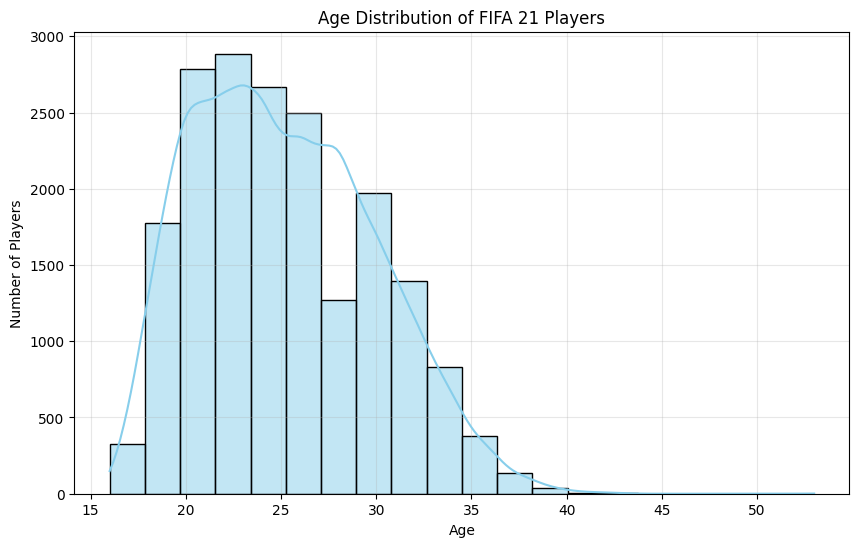


Age Statistics:
count    18979.000000
mean        25.194109
std          4.710520
min         16.000000
25%         21.000000
50%         25.000000
75%         29.000000
max         53.000000
Name: Age, dtype: float64


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size for better readability
plt.figure(figsize=(10, 6))

# Plot histogram with KDE for 'Age'
sns.histplot(df2['Age'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution of FIFA 21 Players')
plt.xlabel('Age')
plt.ylabel('Number of Players')
plt.grid(True, alpha=0.3)  # Add a light grid for reference
plt.show()

# Basic stats for context
print("\nAge Statistics:")
print(df2['Age'].describe())

#### Observations
- **Purpose**: Understand the age range and peak ages of players.
- **Expected Insight**: Most players are likely in their 20s, with fewer older players (e.g., >35).

#### Weekly Wage Distribution

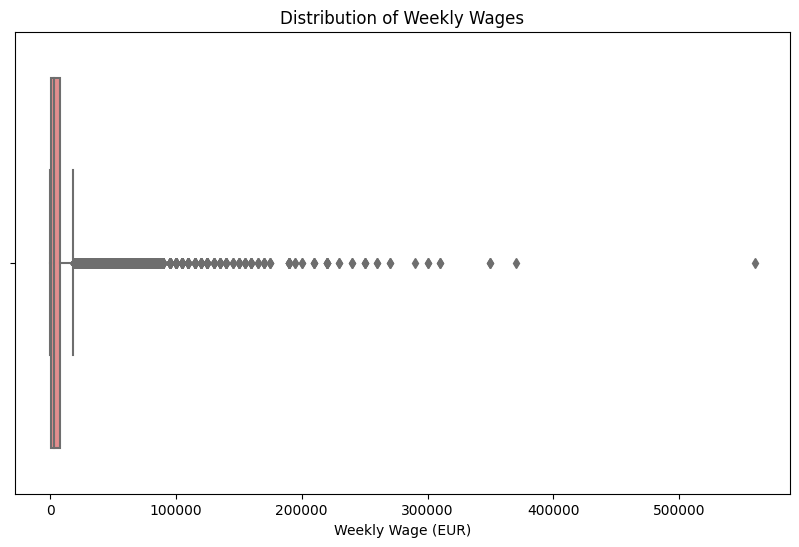


Weekly Wage Statistics:
count     18979.000000
mean       9092.062279
std       19707.021089
min           0.000000
25%        1000.000000
50%        3000.000000
75%        8000.000000
max      560000.000000
Name: Weekly Wage (EUR), dtype: float64


In [40]:
# Box plot for 'Weekly Wage (EUR)'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df2['Weekly Wage (EUR)'], color='lightcoral')
plt.title('Distribution of Weekly Wages')
plt.xlabel('Weekly Wage (EUR)')
plt.show()

# Median and quartiles for reference
print("\nWeekly Wage Statistics:")
print(df2['Weekly Wage (EUR)'].describe())

#### Observations
- **Purpose**: Identify the spread of wages and detect potential outliers.
- **Expected Insight**: Wages are likely skewed, with a few players earning significantly more.

---

### 5.2 Bivariate Analysis

Next, we’ll explore relationships between pairs of variables to see how they interact.

#### Overall Rating (OVA) vs. Weekly Wage

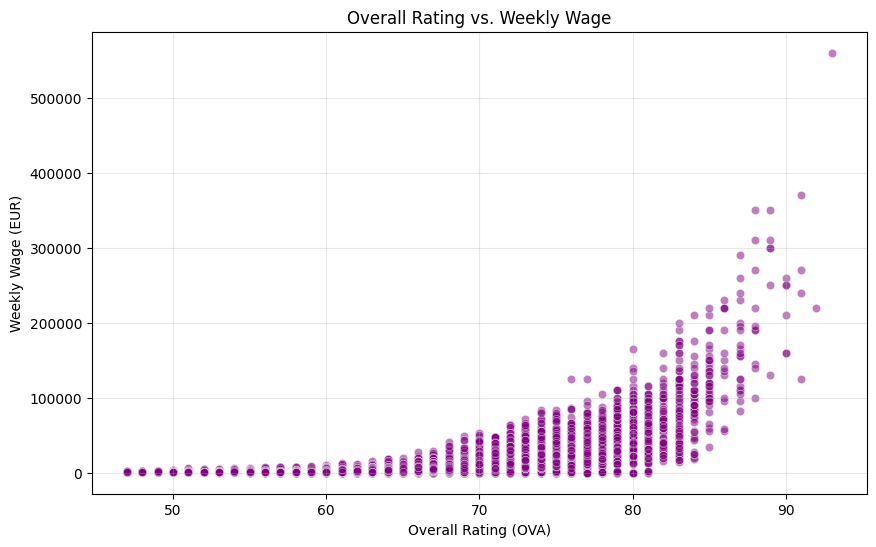


Correlation between OVA and Weekly Wage: 0.5896012814097246


In [41]:
# Scatter plot for 'OVA' vs 'Weekly Wage (EUR)'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='OVA', y='Weekly Wage (EUR)', data=df2, alpha=0.5, color='purple')
plt.title('Overall Rating vs. Weekly Wage')
plt.xlabel('Overall Rating (OVA)')
plt.ylabel('Weekly Wage (EUR)')
plt.grid(True, alpha=0.3)
plt.show()

# Correlation for quantitative insight
print("\nCorrelation between OVA and Weekly Wage:", df2['OVA'].corr(df2['Weekly Wage (EUR)']))

#### Observations
- **Purpose**: Check if higher-rated players earn more.
- **Expected Insight**: A positive correlation is likely, but we may find underpaid high-OVA players.

#### Age vs. Potential (POT)

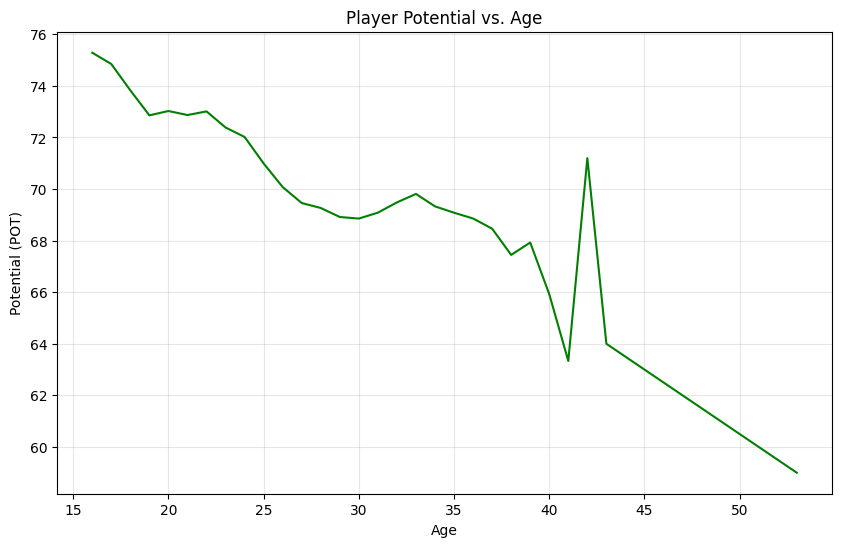

In [42]:
# Line plot for 'Age' vs 'POT'
plt.figure(figsize=(10, 6))
sns.lineplot(x='Age', y='POT', data=df2, color='green', ci=None)  # ci=None removes confidence interval
plt.title('Player Potential vs. Age')
plt.xlabel('Age')
plt.ylabel('Potential (POT)')
plt.grid(True, alpha=0.3)
plt.show()

#### Observations
- **Purpose**: Explore how potential changes with age.
- **Expected Insight**: Younger players likely have higher potential, which decreases with age.

---

### 5.3 Multivariate Analysis

Let’s combine multiple variables to uncover deeper patterns.

#### Top 10 Clubs by Player Count

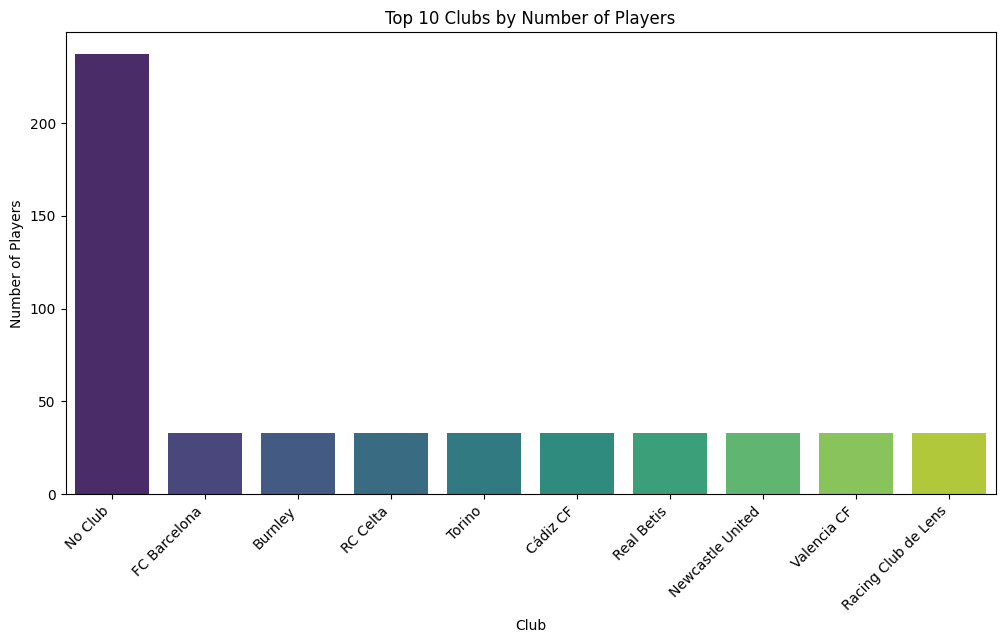


Top 10 Clubs by Player Count:
                  Club  Player Count
0              No Club           237
1         FC Barcelona            33
2              Burnley            33
3             RC Celta            33
4               Torino            33
5             Cádiz CF            33
6           Real Betis            33
7     Newcastle United            33
8          Valencia CF            33
9  Racing Club de Lens            33


In [43]:
# Calculate top 10 clubs by player count
top_clubs = df2['Club'].value_counts().head(10).reset_index()
top_clubs.columns = ['Club', 'Player Count']

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Club', y='Player Count', data=top_clubs, palette='viridis')
plt.title('Top 10 Clubs by Number of Players')
plt.xlabel('Club')
plt.ylabel('Number of Players')
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
plt.show()

# Display the table
print("\nTop 10 Clubs by Player Count:")
print(top_clubs)

#### Observations
- **Purpose**: Identify which clubs have the most players in the dataset.
- **Expected Insight**: Big clubs or those with large squads may dominate.

#### OVA by Best Position

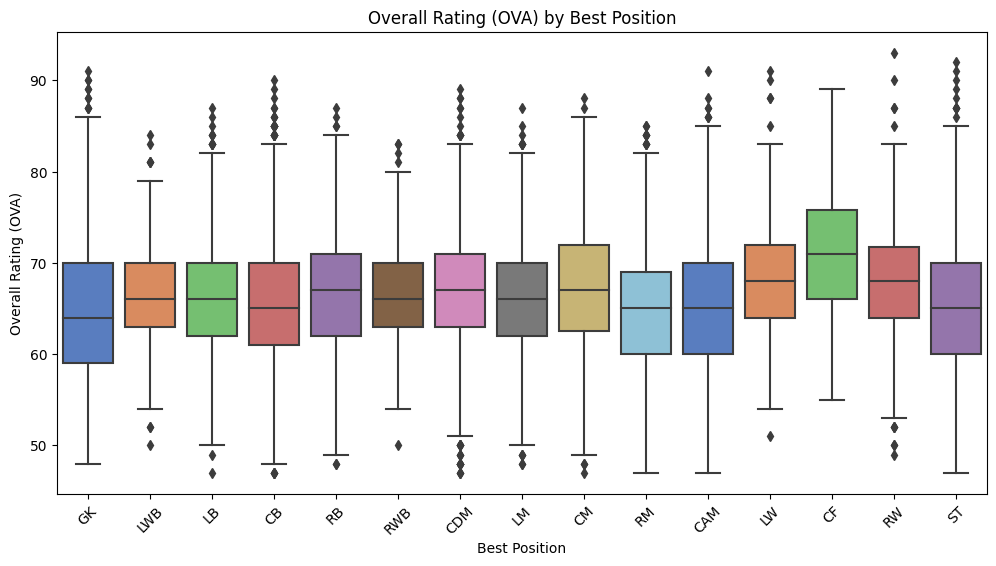

In [44]:
# Define position order for consistency
position_order = ["GK", "LWB", "LB", "CB", "RB", "RWB", "CDM", "LM", "CM", "RM", "CAM", "LW", "CF", "RW", "ST"]

# Box plot for 'OVA' by 'Best Position'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Best Position', y='OVA', data=df2, order=position_order, palette='muted')
plt.title('Overall Rating (OVA) by Best Position')
plt.xlabel('Best Position')
plt.ylabel('Overall Rating (OVA)')
plt.xticks(rotation=45)
plt.show()

#### Observations
- **Purpose**: Compare player ratings across positions.
- **Expected Insight**: Positions like ST or CAM might have higher median OVA due to star players.

---

### Summary Statistics

In [45]:
# Display summary statistics for key numerical columns
key_numerics = ['Age', 'OVA', 'POT', 'Height (cm)', 'Weight (kg)', 'Market Value (EUR)', 'Weekly Wage (EUR)']
print("\nSummary Statistics for Key Numerical Columns:")
print(df2[key_numerics].describe())


Summary Statistics for Key Numerical Columns:
                Age           OVA           POT   Height (cm)   Weight (kg)  \
count  18979.000000  18979.000000  18979.000000  18979.000000  18979.000000   
mean      25.194109     65.718636     71.136414    181.200221     75.019021   
std        4.710520      6.968999      6.114635      6.840054      7.073542   
min       16.000000     47.000000     47.000000    155.000000     50.000000   
25%       21.000000     61.000000     67.000000    176.000000     70.000000   
50%       25.000000     66.000000     71.000000    181.000000     75.000000   
75%       29.000000     70.000000     75.000000    186.000000     80.000000   
max       53.000000     93.000000     95.000000    206.000000    110.000000   

       Market Value (EUR)  Weekly Wage (EUR)  
count        1.897900e+04       18979.000000  
mean         2.865063e+06        9092.062279  
std          7.685154e+06       19707.021089  
min          0.000000e+00           0.000000  
25%   

#### Observations
- **Purpose**: Provide a numerical overview to complement visualizations.
- **Expected Insight**: Highlights ranges, averages, and potential outliers (e.g., max wage).

---

---

## 6. Outlier Detection and Treatment

Outliers can skew our analysis, so we’ll identify and handle them in key numerical columns. This section uses the Interquartile Range (IQR) method to detect and cap outliers, ensuring our data remains realistic for further exploration.

### 6.1 Visualizing Outliers Before Treatment

Let’s start by visualizing the distribution of key numerical columns to spot outliers.

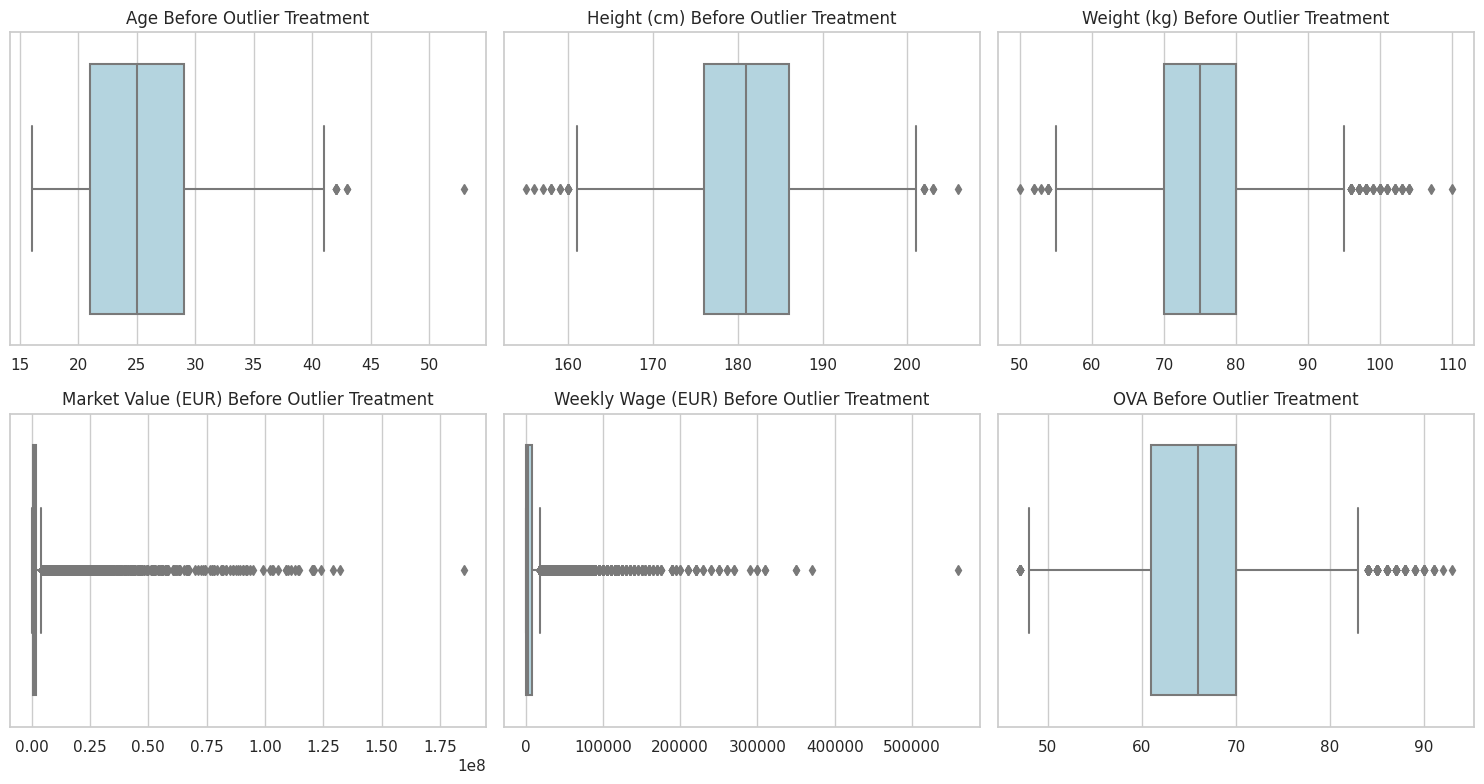

In [46]:
# Set a clean plotting style
sns.set(style="whitegrid")

# Select key numerical columns for outlier analysis (focus on our objectives)
key_numerics = ['Age', 'Height (cm)', 'Weight (kg)', 'Market Value (EUR)', 'Weekly Wage (EUR)', 'OVA']

# Calculate layout for subplots
n_cols = 3
n_rows = (len(key_numerics) + n_cols - 1) // n_cols

# Create boxplots
plt.figure(figsize=(n_cols * 5, n_rows * 4))
for i, col in enumerate(key_numerics, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df2[col], color='lightblue')
    plt.title(f'{col} Before Outlier Treatment', fontsize=12)
    plt.xlabel('')
plt.tight_layout()
plt.show()


#### Observations
- **Purpose**: Visualize the spread and extreme values in key columns.
- **Expected Insight**: Columns like `'Weekly Wage (EUR)'` and `'Market Value (EUR)'` likely show significant outliers due to superstar players.

---

### 6.2 Handling Outliers with IQR Method

We’ll use the IQR method (1.5x multiplier) to cap outliers at reasonable bounds, preserving data integrity without removing rows.

In [47]:
def cap_outliers_iqr(df, columns, multiplier=1.5):
    """
    Cap outliers in specified columns using the IQR method.
    - multiplier: Factor to define bounds (default 1.5).
    - Returns: DataFrame with capped values.
    """
    df_capped = df.copy()
    for col in columns:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        # Cap values outside bounds
        df_capped[col] = np.clip(df_capped[col], lower_bound, upper_bound)
        
        # Report number of capped values
        capped_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        print(f"Capped {capped_count} outliers in '{col}'")
    
    return df_capped

# Apply outlier capping to key numerical columns
df2_clean = cap_outliers_iqr(df2, key_numerics)

# Verify no extreme outliers remain
for col in key_numerics:
    Q1 = df2_clean[col].quantile(0.25)
    Q3 = df2_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    bounds = [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]
    remaining = df2_clean[(df2_clean[col] < bounds[0]) | (df2_clean[col] > bounds[1])].shape[0]
    print(f"Remaining outliers in '{col}': {remaining}")

Capped 8 outliers in 'Age'
Capped 22 outliers in 'Height (cm)'
Capped 74 outliers in 'Weight (kg)'
Capped 2297 outliers in 'Market Value (EUR)'
Capped 2356 outliers in 'Weekly Wage (EUR)'
Capped 156 outliers in 'OVA'
Remaining outliers in 'Age': 0
Remaining outliers in 'Height (cm)': 0
Remaining outliers in 'Weight (kg)': 0
Remaining outliers in 'Market Value (EUR)': 0
Remaining outliers in 'Weekly Wage (EUR)': 0
Remaining outliers in 'OVA': 0


#### Observations
- **Purpose**: Cap extreme values to reduce skew while keeping all players.
- **Method**: Values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR are set to the nearest bound.
- **Expected Insight**: High wages and values will be moderated, but not eliminated.

---

### 6.3 Visualizing Outliers After Treatment

Let’s confirm the effect of capping by visualizing the same columns again.

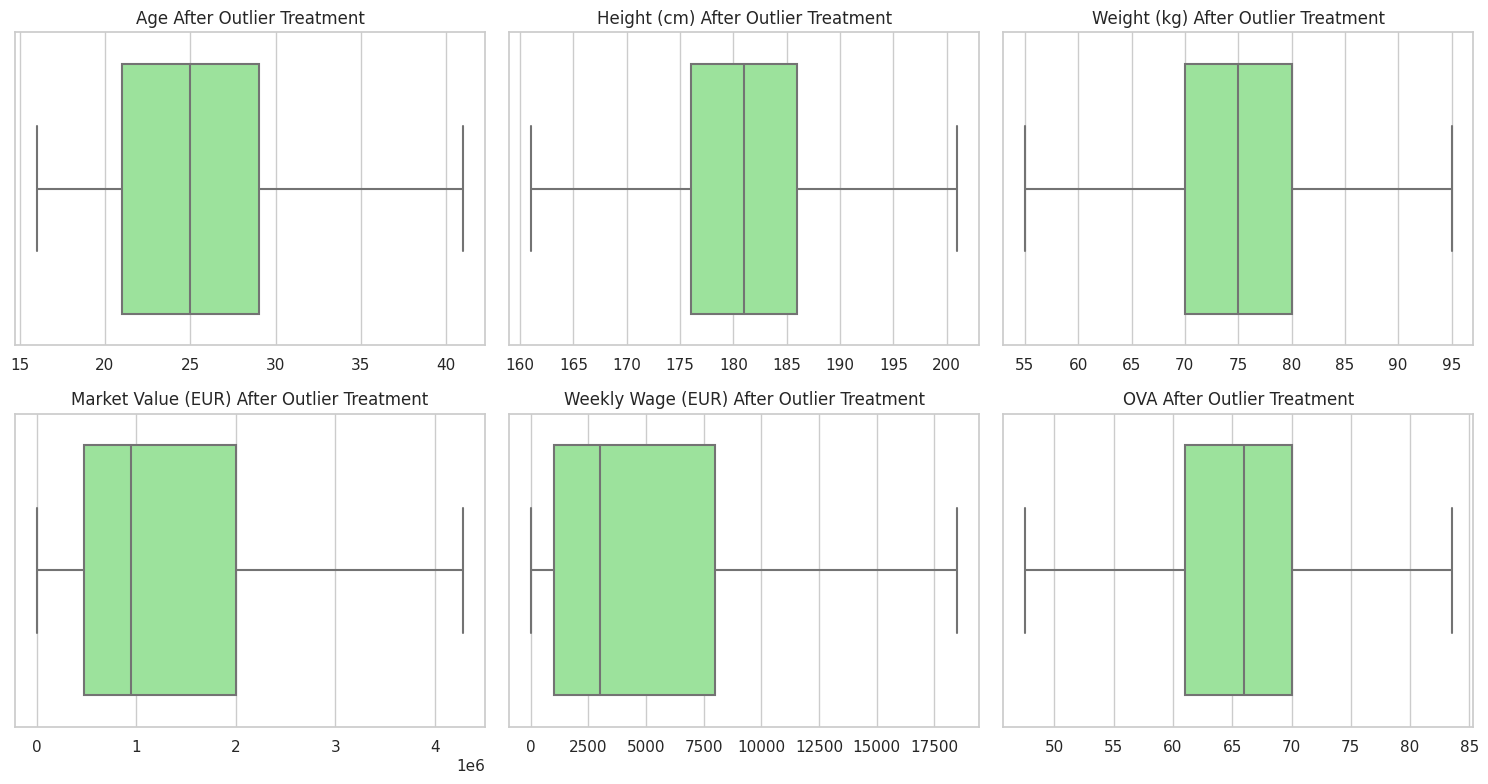

In [48]:
# Boxplots after capping outliers
plt.figure(figsize=(n_cols * 5, n_rows * 4))
for i, col in enumerate(key_numerics, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df2_clean[col], color='lightgreen')
    plt.title(f'{col} After Outlier Treatment', fontsize=12)
    plt.xlabel('')
plt.tight_layout()
plt.show()

#### Observations
- **Purpose**: Compare distributions before and after capping.
- **Expected Insight**: Boxplots should show reduced whiskers, with no values beyond the capped bounds.

---

### 6.4 Summary of Changes

Let’s quantify the impact on key statistics.

In [49]:
# Compare statistics before and after
print("\nStatistics Before Outlier Treatment:")
print(df2[key_numerics].describe())
print("\nStatistics After Outlier Treatment:")
print(df2_clean[key_numerics].describe())


Statistics Before Outlier Treatment:
                Age   Height (cm)   Weight (kg)  Market Value (EUR)  \
count  18979.000000  18979.000000  18979.000000        1.897900e+04   
mean      25.194109    181.200221     75.019021        2.865063e+06   
std        4.710520      6.840054      7.073542        7.685154e+06   
min       16.000000    155.000000     50.000000        0.000000e+00   
25%       21.000000    176.000000     70.000000        4.750000e+05   
50%       25.000000    181.000000     75.000000        9.500000e+05   
75%       29.000000    186.000000     80.000000        2.000000e+06   
max       53.000000    206.000000    110.000000        1.855000e+08   

       Weekly Wage (EUR)           OVA  
count       18979.000000  18979.000000  
mean         9092.062279     65.718636  
std         19707.021089      6.968999  
min             0.000000     47.000000  
25%          1000.000000     61.000000  
50%          3000.000000     66.000000  
75%          8000.000000     70.000

#### Observations
- **Purpose**: Assess how capping affects means, max/min values, and spread.
- **Expected Insight**: Max values should decrease significantly in skewed columns (e.g., `'Weekly Wage (EUR)'`).

---

## 7. Advanced Visualization

With the data cleaned and outliers handled, let’s create insightful visualizations to explore distributions, relationships, and global patterns. This section uses a mix of static and interactive plots to address our objectives and uncover trends.

---

### 7.1 Distribution of Key Metrics

We’ll visualize the distribution of critical numerical columns to understand their spread.

#### Histogram of Key Variables

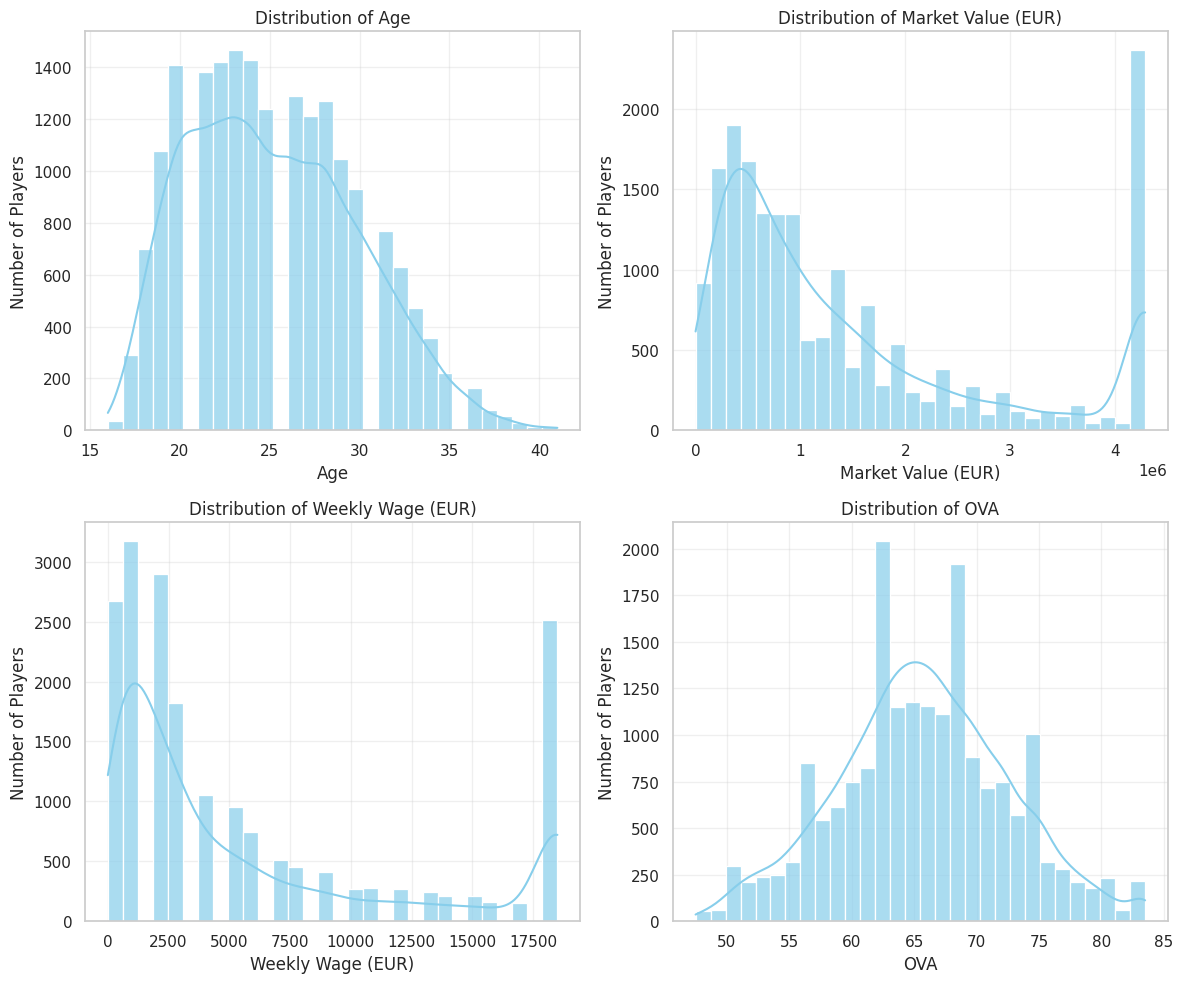

In [50]:
# Select key numerical columns for visualization
key_metrics = ['Age', 'Market Value (EUR)', 'Weekly Wage (EUR)', 'OVA']

# Set up the subplot grid
n_cols = 2
n_rows = 2
plt.figure(figsize=(n_cols * 6, n_rows * 5))

# Plot histograms with KDE
for i, col in enumerate(key_metrics, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df2_clean[col], bins=30, kde=True, color='skyblue', alpha=0.7)
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Number of Players')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Observations
- **Purpose**: Show the spread and shape of key variables.
- **Expected Insight**: `'Weekly Wage (EUR)'` and `'Market Value (EUR)'` are likely right-skewed due to a few high earners.

---

### 7.2 Correlation Analysis

Let’s explore relationships between numerical variables using a heatmap.

#### Correlation Heatmap of Key Features

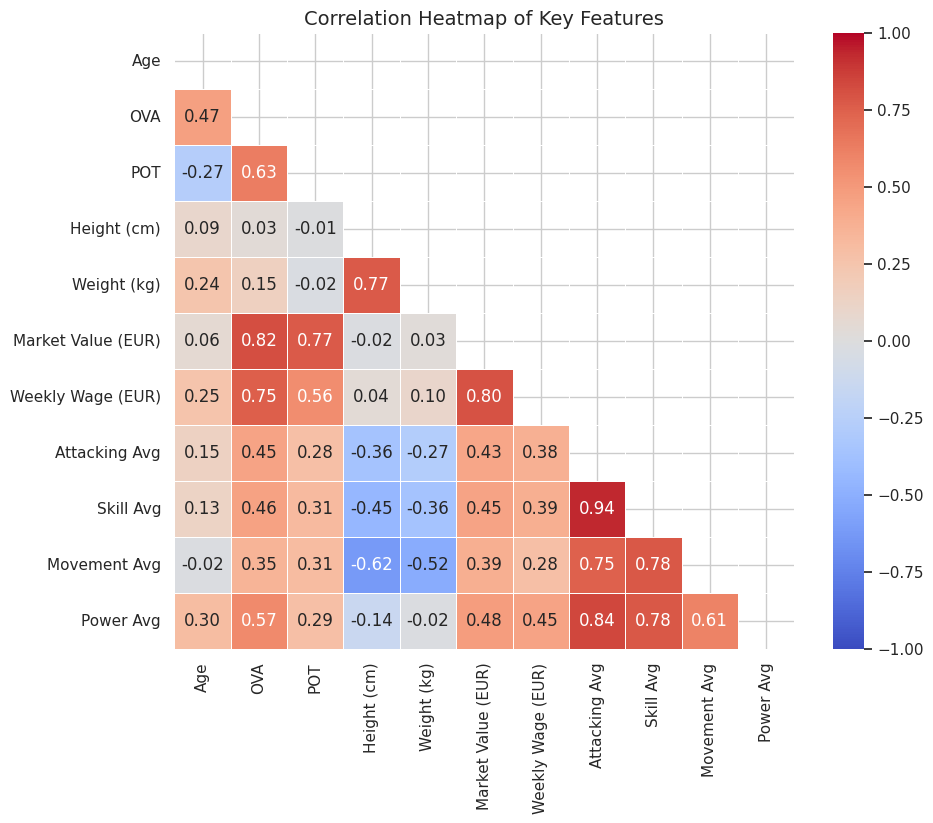


Strong Correlations (|r| > 0.6):
OVA                 POT                   0.629318
                    Market Value (EUR)    0.819511
                    Weekly Wage (EUR)     0.754288
POT                 OVA                   0.629318
                    Market Value (EUR)    0.767009
Height (cm)         Weight (kg)           0.773320
                    Movement Avg         -0.618544
Weight (kg)         Height (cm)           0.773320
Market Value (EUR)  OVA                   0.819511
                    POT                   0.767009
                    Weekly Wage (EUR)     0.797045
Weekly Wage (EUR)   OVA                   0.754288
                    Market Value (EUR)    0.797045
Attacking Avg       Skill Avg             0.935083
                    Movement Avg          0.748360
                    Power Avg             0.839548
Skill Avg           Attacking Avg         0.935083
                    Movement Avg          0.775147
                    Power Avg             0.7780

In [51]:
# Select relevant columns for correlation
corr_cols = ['Age', 'OVA', 'POT', 'Height (cm)', 'Weight (kg)', 'Market Value (EUR)', 
             'Weekly Wage (EUR)', 'Attacking Avg', 'Skill Avg', 'Movement Avg', 'Power Avg']

# Compute correlation matrix
corr_matrix = df2_clean[corr_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, 
            center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Key Features', fontsize=14)
plt.show()

# Highlight strong correlations
strong_corr = corr_matrix[(corr_matrix.abs() > 0.6) & (corr_matrix != 1.0)].stack()
print("\nStrong Correlations (|r| > 0.6):")
print(strong_corr)

#### Observations
- **Purpose**: Identify strong relationships between variables.
- **Expected Insight**: `'OVA'` likely correlates with `'Market Value (EUR)'` and `'Weekly Wage (EUR)'`.

---

### 7.3 Global Player Distribution

Let’s visualize player counts by nationality on a world map.

#### Interactive Choropleth Map

In [52]:
import plotly.express as px

# Count players by nationality
nat_counts = df2_clean['Nationality'].value_counts().reset_index()
nat_counts.columns = ['Nationality', 'Player Count']

# Create interactive choropleth map
fig = px.choropleth(
    nat_counts,
    locations='Nationality',
    locationmode='country names',
    color='Player Count',
    hover_name='Nationality',
    hover_data={'Player Count': True},
    color_continuous_scale='Viridis',
    title='Player Distribution by Nationality',
    width=1000,
    height=600
)
fig.show()

#### Observations
- **Purpose**: Show the geographical spread of players.
- **Expected Insight**: Countries like England, Germany, and Spain likely dominate due to large leagues.

---

### 7.4 Top Players and Clubs

Let’s highlight top performers and valuable clubs.

#### Top 10 Players by OVA

In [53]:
# Get top 10 players by OVA
top_10_players = df2_clean.nlargest(10, 'OVA')

# Bar plot with hover info
fig = px.bar(
    top_10_players,
    x='Best Position',
    y='OVA',
    hover_data=['LongName', 'Club'],
    color='OVA',
    color_continuous_scale='Blues',
    title='Top 10 Players by Overall Rating (OVA)',
    width=800,
    height=500
)
fig.update_layout(xaxis_title='Best Position', yaxis_title='Overall Rating (OVA)')
fig.show()

#### Observations
- **Purpose**: Identify the best players and their positions.
- **Expected Insight**: Star players (e.g., Messi, Ronaldo) likely appear with high OVA.

---

### Player Skill Profiles

To dive deeper into the characteristics of top players, we’ll use a radar chart to visualize the skill averages (e.g., Attacking, Skill, Movement) of the top 10 players by `'OVA'`. This highlights their strengths and weaknesses in a compact, comparative way.

#### Radar Chart of Top 10 Players’ Skills

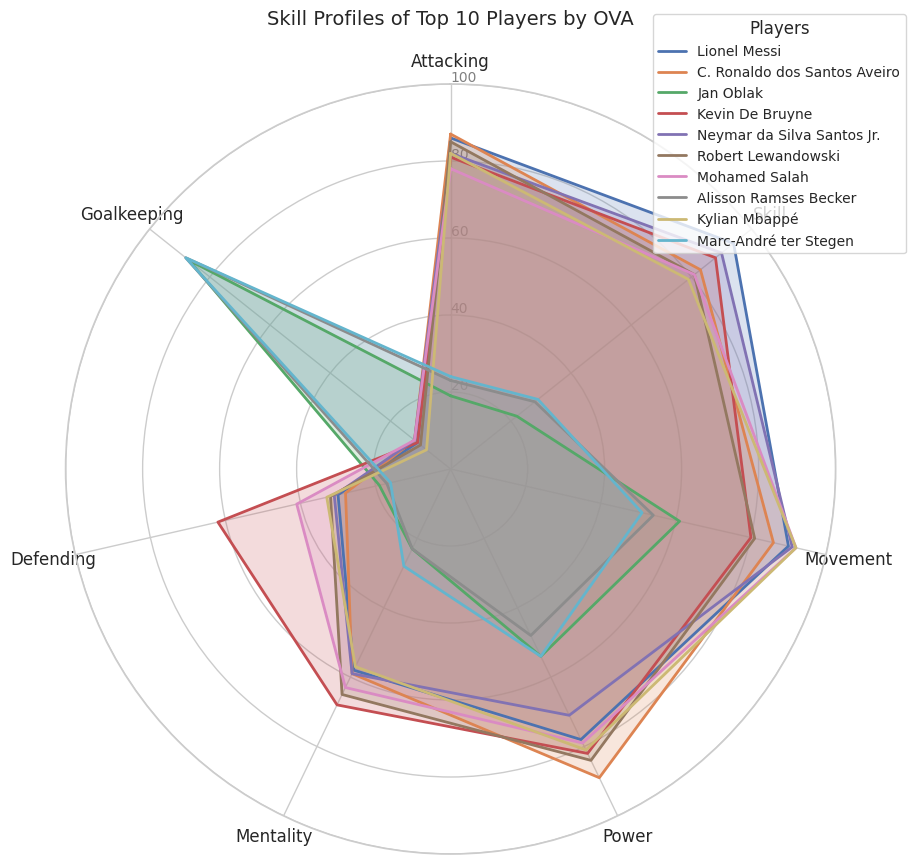

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi

# Select top 10 players by OVA
top_10 = df2_clean.nlargest(10, 'OVA')

# Define skill columns to plot
skill_cols = ['Attacking Avg', 'Skill Avg', 'Movement Avg', 'Power Avg', 'Mentality Avg', 'Defending Avg', 'Goalkeeping Avg']
labels = ['Attacking', 'Skill', 'Movement', 'Power', 'Mentality', 'Defending', 'Goalkeeping']  # Shorter labels for clarity

# Prepare data for radar chart
values = top_10[skill_cols].values
player_names = top_10['LongName'].values

# Number of variables (skills)
n = len(labels)

# Compute angle for each axis (corrected)
angles = [i * (2 * pi / n) for i in range(n)]
angles += angles[:1]  # Complete the loop

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
ax.set_theta_offset(pi / 2)  # Start at the top
ax.set_theta_direction(-1)   # Clockwise

# Draw axis lines and labels
plt.xticks(angles[:-1], labels, fontsize=12)

# Set y-axis limits and labels
ax.set_rlabel_position(0)
plt.yticks([20, 40, 60, 80, 100], ["20", "40", "60", "80", "100"], color="grey", size=10)
plt.ylim(0, 100)

# Plot each player
for i, player_data in enumerate(values):
    data = player_data.tolist()
    data += data[:1]  # Complete the loop
    ax.plot(angles, data, linewidth=2, linestyle='solid', label=player_names[i])
    ax.fill(angles, data, alpha=0.2)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=10, title='Players')

# Title
plt.title('Skill Profiles of Top 10 Players by OVA', size=14, pad=20)
plt.show()

#### Total Market Value by Club

In [55]:
# Treemap of total market value by club
df_valid = df2_clean[df2_clean['Market Value (EUR)'].notna() & (df2_clean['Market Value (EUR)'] > 0)]  # Filter out NaN or zero values
fig = px.treemap(
    df_valid,
    path=['Club'],
    values='Market Value (EUR)',
    title='Total Market Value of Players by Club',
    color='Market Value (EUR)',
    color_continuous_scale='RdYlGn',
    width=1000,
    height=600
)
fig.show()

#### Observations
- **Purpose**: Visualize which clubs have the most valuable squads.
- **Expected Insight**: Top clubs like Real Madrid or Manchester City should stand out.

---

### 7.5 Position-Based Insights

Let’s explore how age, OVA, and growth vary by position.

#### Age vs. OVA with Growth (Potential - OVA)

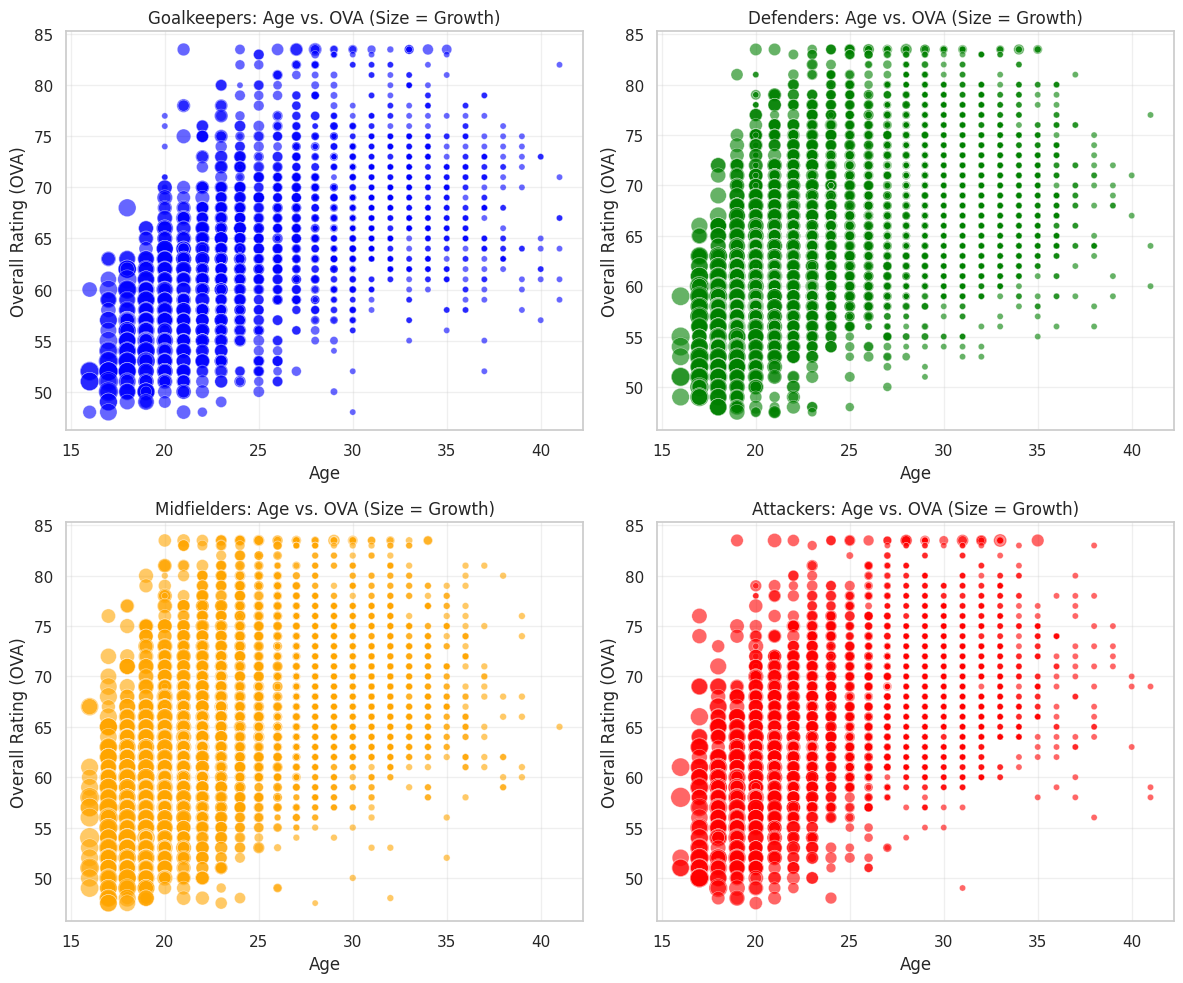

In [56]:
# Calculate growth
df2_clean['Growth'] = df2_clean['POT'] - df2_clean['OVA']

# Define position groups
position_groups = {
    'Goalkeepers': ['GK'],
    'Defenders': ['LB', 'CB', 'RB', 'LWB', 'RWB', 'CDM'],
    'Midfielders': ['LM', 'CM', 'RM', 'CAM'],
    'Attackers': ['LW', 'CF', 'RW', 'ST']
}

# Colors for each group
group_colors = {'Goalkeepers': 'blue', 'Defenders': 'green', 'Midfielders': 'orange', 'Attackers': 'red'}

# Plot subplots for each group
plt.figure(figsize=(12, 10))
for i, (group, positions) in enumerate(position_groups.items(), 1):
    plt.subplot(2, 2, i)
    group_data = df2_clean[df2_clean['Best Position'].isin(positions)]
    sns.scatterplot(
        data=group_data,
        x='Age',
        y='OVA',
        size='Growth',
        sizes=(20, 200),
        hue='Best Position',  # Use 'Best Position' column for hue
        palette=[group_colors[group]],  # Apply the group color
        alpha=0.6,
        legend=False
    )
    plt.title(f'{group}: Age vs. OVA (Size = Growth)', fontsize=12)
    plt.xlabel('Age')
    plt.ylabel('Overall Rating (OVA)')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## 8. Insights and Further Analysis

After cleaning, exploring, and visualizing the FIFA 21 dataset, let’s extract key insights and explore additional questions to deepen our understanding. This section ties our findings to the initial objectives and sets the stage for future analysis.

---

### 8.1 Identifying Undervalued Players

Let’s find players with high `'Market Value (EUR)'` but relatively low `'Weekly Wage (EUR)'`—potential bargains for clubs.

In [57]:
# Calculate value-to-wage ratio
df2_clean['Value_to_Wage_Ratio'] = df2_clean['Market Value (EUR)'] / df2_clean['Weekly Wage (EUR)']

# Filter top 10 undervalued players (high value, low wage, high OVA)
undervalued = df2_clean[df2_clean['OVA'] > 80].nlargest(10, 'Value_to_Wage_Ratio')
undervalued_summary = undervalued[['LongName', 'Club', 'OVA', 'Market Value (EUR)', 'Weekly Wage (EUR)', 'Value_to_Wage_Ratio']]

# Display results
print("\nTop 10 Undervalued Players (High Value, Low Wage):")
print(undervalued_summary)

# Visualize
import plotly.express as px
fig = px.scatter(
    undervalued,
    x='Weekly Wage (EUR)',
    y='Market Value (EUR)',
    size='OVA',
    color='Value_to_Wage_Ratio',
    hover_data=['LongName', 'Club'],
    title='Undervalued Players: Market Value vs. Weekly Wage',
    width=800,
    height=600
)
fig.show()


Top 10 Undervalued Players (High Value, Low Wage):
                         LongName              Club   OVA  Market Value (EUR)  \
346      Ismaily Gonçalves dos S.  Shakhtar Donetsk  81.0           4287500.0   
354          Marlos Romero Bonfim  Shakhtar Donetsk  81.0           4287500.0   
358        Taison Barcellos Freda  Shakhtar Donetsk  81.0           4287500.0   
350          Andrés Iniesta Luján       Vissel Kobe  81.0           4287500.0   
366  Képler Laveran Lima Ferreira          FC Porto  81.0           4287500.0   
180                Blaise Matuidi       Inter Miami  83.0           4287500.0   
283                Josef Martínez    Atlanta United  81.0           4287500.0   
314          Odisseas Vlachodimos        SL Benfica  81.0           4287500.0   
252             Agustín Marchesín          FC Porto  82.0           4287500.0   
210                   Carlos Vela    Los Angeles FC  83.0           4287500.0   

     Weekly Wage (EUR)  Value_to_Wage_Ratio  
346       

#### Observations
- **Purpose**: Address the objective of finding highly valuable but underpaid players.
- **Expected Insight**: Players with high OVA and value-to-wage ratios could be transfer targets.

---

### 8.2 Club Investment Efficiency

Let’s evaluate which clubs get the most OVA per euro spent on wages.

In [58]:
# Aggregate total wage and average OVA by club
club_efficiency = df2_clean.groupby('Club').agg({
    'Weekly Wage (EUR)': 'sum',
    'OVA': 'mean'
}).reset_index()

# Calculate efficiency (OVA per euro of wage)
club_efficiency['OVA_per_Euro'] = club_efficiency['OVA'] / club_efficiency['Weekly Wage (EUR)']

# Top 10 efficient clubs
top_efficient = club_efficiency.nlargest(10, 'OVA_per_Euro')

# Display results
print("\nTop 10 Clubs by OVA per Euro of Wage:")
print(top_efficient)

# Treemap visualization
fig = px.treemap(
    top_efficient,
    path=['Club'],
    values='OVA',
    color='OVA_per_Euro',
    color_continuous_scale='Blues',
    title='Top 10 Efficient Clubs: OVA per Euro of Wage',
    width=1000,
    height=600
)
fig.show()


Top 10 Clubs by OVA per Euro of Wage:
                       Club  Weekly Wage (EUR)        OVA  OVA_per_Euro
423                 No Club                0.0  68.835443           inf
53                Aragua FC            10500.0  61.238095      0.005832
377     Llaneros de Guanare            10000.0  58.100000      0.005810
125  Central Coast Mariners            10350.0  58.833333      0.005684
173                Cusco FC            12000.0  62.625000      0.005219
658            Waterford FC            10650.0  53.904762      0.005061
10    AC Mineros de Guayana            12500.0  60.720000      0.004858
144      Club Atlético Grau            12500.0  60.080000      0.004806
301            HJK Helsinki            12900.0  61.520000      0.004769
588  St. Patrick's Athletic            12200.0  57.391304      0.004704


#### Observations
- **Purpose**: Identify clubs that optimize talent per wage spent.
- **Expected Insight**: Smaller clubs might outperform big spenders in efficiency.

---

### 8.3 Predictive Potential Check

Let’s see if young players (age ≤ 23) with high growth potential are undervalued.

In [59]:
# Filter young players with high growth
young_talents = df2_clean[(df2_clean['Age'] <= 23) & (df2_clean['Growth'] > 5)]

# Summary of top 10 by market value
top_young = young_talents.nsmallest(10, 'Market Value (EUR)')[['LongName', 'Club', 'Age', 'OVA', 'POT', 'Growth', 'Market Value (EUR)']]

# Display results
print("\nTop 10 Young Talents with High Growth and Low Market Value:")
print(top_young)

# Scatter plot
fig = px.scatter(
    young_talents,
    x='Age',
    y='Growth',
    size='Market Value (EUR)',
    color='OVA',
    hover_data=['LongName', 'Club'],
    title='Young Talents: Growth vs. Age',
    width=800,
    height=600
)
fig.show()


Top 10 Young Talents with High Growth and Low Market Value:
                  LongName     Club  Age   OVA  POT  Growth  \
2788       Mostafa Mohamed  No Club   22  73.0   80     7.0   
2989        Kiril Despodov  No Club   23  73.0   79     6.0   
3433         Ramadan Sobhi  No Club   23  72.0   78     6.0   
6254    Mathías Villasanti  No Club   23  69.0   75     6.0   
6309   Santiago Arzamendia  No Club   22  69.0   79    10.0   
9873     Kristian Dimitrov  No Club   23  65.0   73     8.0   
10929          Liam Millar  No Club   20  64.0   76    12.0   
11783      Callum McCowatt  No Club   21  64.0   74    10.0   
12240         Michael Woud  No Club   21  63.0   74    11.0   
12914       András Schäfer  No Club   21  63.0   78    15.0   

       Market Value (EUR)  
2788                  0.0  
2989                  0.0  
3433                  0.0  
6254                  0.0  
6309                  0.0  
9873                  0.0  
10929                 0.0  
11783                

---

## Conclusion

This notebook transformed a messy FIFA 21 dataset into a clean, actionable resource, achieving our initial objectives and more. Here’s a summary of our journey and findings:

- **Data Cleaning**: Converted text-based columns (e.g., `'Height'`, `'Value'`, `'Contract'`) into numerical and structured formats, removing noise like `\n` and `★`.
- **Exploration**: Uncovered distributions (e.g., most players are 20-30 years old) and relationships (e.g., OVA correlates with wages but with exceptions).
- **Outliers**: Capped extreme values in key columns (e.g., wages, values) to ensure robust analysis without losing data.
- **Visualization**: Used static and interactive plots to reveal global patterns (e.g., player counts by country), top performers, and position-based trends.
- **Insights**: Identified undervalued players, efficient clubs, and young talents with high growth potential, directly addressing our goals of finding bargains and understanding value dynamics.

### Key Takeaways
- **Player Value**: High OVA players often command high wages, but exceptions exist—ideal targets for cost-conscious clubs.
- **Club Efficiency**: Some smaller clubs maximize talent per euro spent, offering lessons for big spenders.
- **Future Stars**: Young players with significant growth potential are often undervalued, ripe for investment.

### Future Directions
- **Deeper Analysis**: Model player value or performance predictors.
- **Real-World Application**: Share insights with football analysts or scouts.
- **Dataset Expansion**: Incorporate newer FIFA data or additional metrics (e.g., match stats).

This analysis not only cleaned a chaotic dataset but also turned it into a tool for strategic football decisions. The process showcased the power of data cleaning, exploration, and visualization in uncovering hidden stories within numbers.